In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

Processing...
Done!


In [17]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


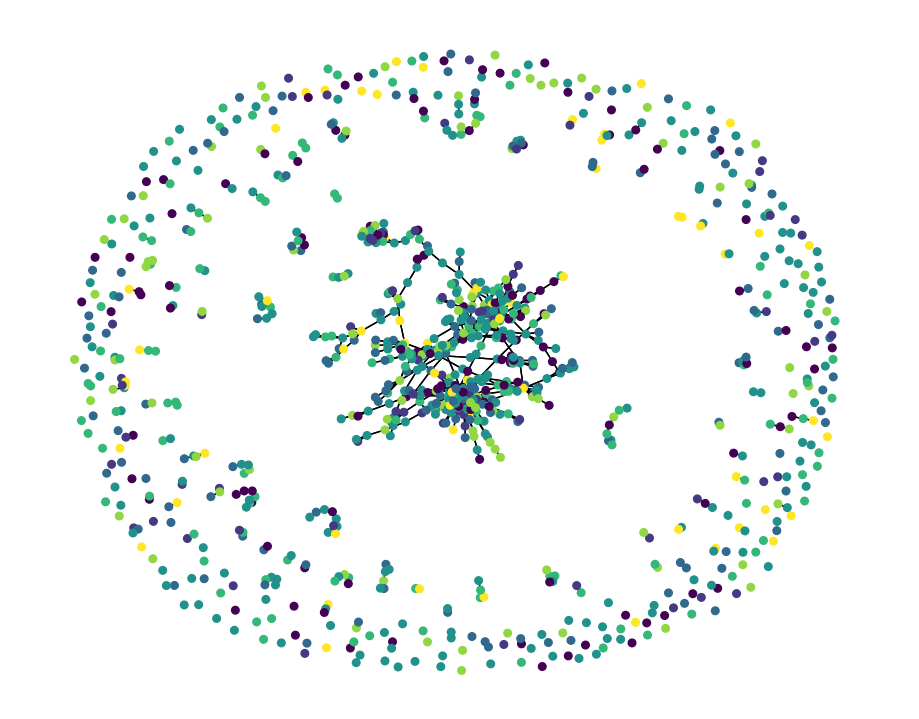

In [5]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [7]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

In [8]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [9]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [13]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc
  
  
mlp = MLP()#.to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.972, Val Acc: 0.620
Epoch: 020, Train Loss: 0.123, Val Acc: 0.727
Epoch: 030, Train Loss: 0.018, Val Acc: 0.727
Epoch: 040, Train Loss: 0.013, Val Acc: 0.734
Epoch: 050, Train Loss: 0.015, Val Acc: 0.727
Epoch: 060, Train Loss: 0.013, Val Acc: 0.742
Epoch: 070, Train Loss: 0.011, Val Acc: 0.745
Epoch: 080, Train Loss: 0.009, Val Acc: 0.734
Epoch: 090, Train Loss: 0.009, Val Acc: 0.734
Epoch: 100, Train Loss: 0.008, Val Acc: 0.738
Epoch: 110, Train Loss: 0.008, Val Acc: 0.738
Epoch: 120, Train Loss: 0.007, Val Acc: 0.738
Epoch: 130, Train Loss: 0.007, Val Acc: 0.738
Epoch: 140, Train Loss: 0.007, Val Acc: 0.738
Epoch: 150, Train Loss: 0.006, Val Acc: 0.738
Test Acc: 0.736


In [12]:
import torch

In [15]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN()#.to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.934, Val Acc: 0.742
Epoch: 020, Train Loss: 0.405, Val Acc: 0.841
Epoch: 030, Train Loss: 0.231, Val Acc: 0.860
Epoch: 040, Train Loss: 0.168, Val Acc: 0.849
Epoch: 050, Train Loss: 0.140, Val Acc: 0.856
Epoch: 060, Train Loss: 0.127, Val Acc: 0.845
Epoch: 070, Train Loss: 0.118, Val Acc: 0.845
Epoch: 080, Train Loss: 0.111, Val Acc: 0.845
Epoch: 090, Train Loss: 0.104, Val Acc: 0.845
Epoch: 100, Train Loss: 0.098, Val Acc: 0.845
Epoch: 110, Train Loss: 0.093, Val Acc: 0.849
Epoch: 120, Train Loss: 0.088, Val Acc: 0.845
Epoch: 130, Train Loss: 0.084, Val Acc: 0.845
Epoch: 140, Train Loss: 0.081, Val Acc: 0.849
Epoch: 150, Train Loss: 0.078, Val Acc: 0.841
Epoch: 160, Train Loss: 0.076, Val Acc: 0.841
Epoch: 170, Train Loss: 0.074, Val Acc: 0.841
Epoch: 180, Train Loss: 0.072, Val Acc: 0.841
Epoch: 190, Train Loss: 0.070, Val Acc: 0.845
Epoch: 200, Train Loss: 0.068, Val Acc: 0.841
Test Acc: 0.873


In [16]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [23]:
graph.x.shape

torch.Size([2708, 1433])

In [19]:
graph.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [30]:
graph.edge_index[0][3]

tensor(1)

In [24]:
graph.edge_index.shape

torch.Size([2, 10556])

In [26]:
graph.edge_index.max()

tensor(2707)

In [31]:
(graph.edge_index[0] == 633).nonzero(as_tuple=True)


(tensor([2569, 2570, 2571]),)

In [33]:
graph.edge_index[1][2569]

tensor(0)